In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [22]:
data=pd.read_csv("loan_data_final.csv")

In [23]:
data.head()

,politique_de_credit,objet__du_pret,taux_interet,mensualité,revenu_annuel_log,ratio_endettement,score_credit,duree_ligne_credit,solde_renouvelable,taux_utilisation_credit,demandes_credit_6_mois,incidents_paiement_2_ans,dossiers_publics_derogatoires,pret_non_remboursé
0,oui,consolidation_dettes,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,non
1,oui,carte_crédit,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,non
2,oui,consolidation_dettes,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,non
3,oui,consolidation_dettes,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,non
4,oui,carte_crédit,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,non


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   politique_de_credit            9578 non-null   object 
 1   objet__du_pret                 9578 non-null   object 
 2   taux_interet                   9578 non-null   float64
 3   mensualité                     9578 non-null   float64
 4   revenu_annuel_log              9578 non-null   float64
 5   ratio_endettement              9578 non-null   float64
 6   score_credit                   9578 non-null   int64  
 7   duree_ligne_credit             9578 non-null   float64
 8   solde_renouvelable             9578 non-null   int64  
 9   taux_utilisation_credit        9578 non-null   float64
 10  demandes_credit_6_mois         9578 non-null   int64  
 11  incidents_paiement_2_ans       9578 non-null   int64  
 12  dossiers_publics_derogatoires  9578 non-null   i

In [25]:
# Renommé la variable'pret_non_remboursé' en'statut_prêt'
data.rename(columns={'pret_non_remboursé': 'statut_prêt'}, inplace=True)

# Display the updated column names to confirm the change
data.columns.tolist()


['politique_de_credit',
 'objet__du_pret',
 'taux_interet',
 'mensualité',
 'revenu_annuel_log',
 'ratio_endettement',
 'score_credit',
 'duree_ligne_credit',
 'solde_renouvelable',
 'taux_utilisation_credit',
 'demandes_credit_6_mois',
 'incidents_paiement_2_ans',
 'dossiers_publics_derogatoires',
 'statut_prêt']

In [26]:
# Modifier la valeur de 'statut_prêt' ccolonne: changer 'oui' par 'non_remboursé' et'non' par'remboursé'
data['statut_prêt'] = data['statut_prêt'].replace({'oui': 'non_remboursé', 'non': 'remboursé'})

# Affciher les valeurs uniques de la colonne 'statut_prêt'
data['statut_prêt'].unique()


array(['remboursé', 'non_remboursé'], dtype=object)

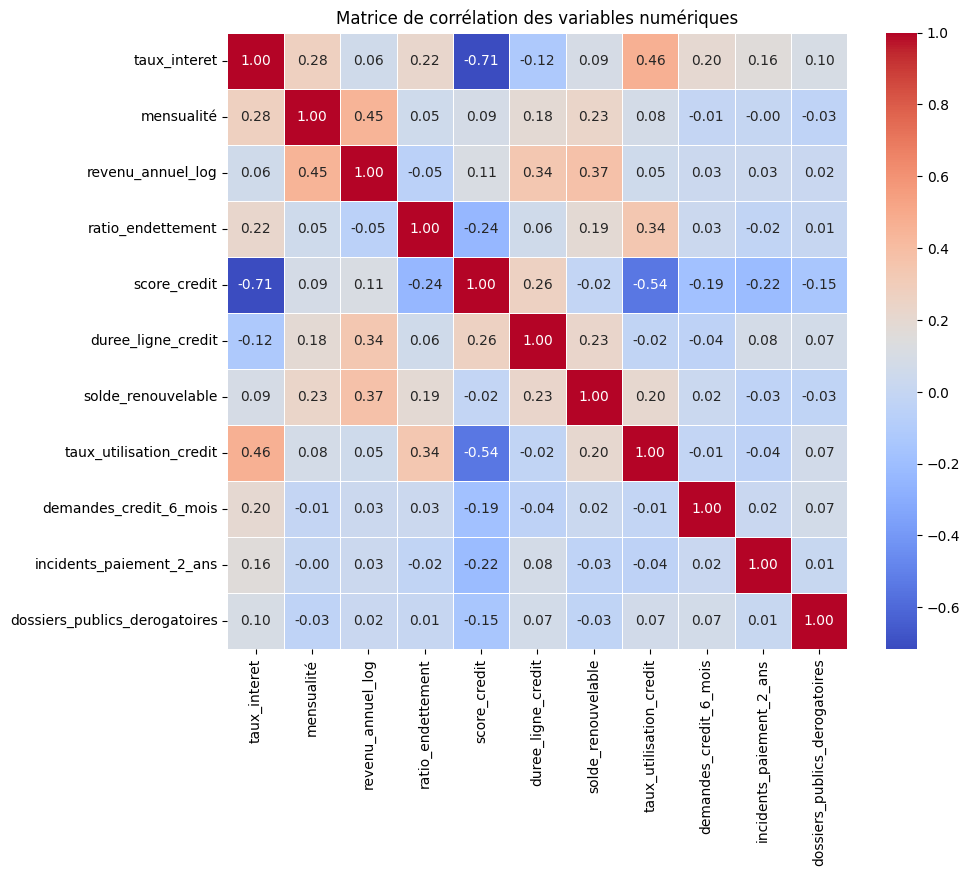

In [27]:
# Sélectionner les colonnes numériques
numeric_columns = data.select_dtypes(include=['float64', 'int64'])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()


Corrélations Positives Fortes
Mensualité et Taux d'intérêt (0.96) : Les prêts avec des mensualités plus élevées ont généralement des taux d'intérêt plus élevés.
Dossier public dérogatoire et Incidents de paiement (0.61) : Les clients ayant des incidents de paiement au cours des 2 dernières années ont également tendance à avoir des dossiers publics dérogatoires.
Corrélations Négatives Fortes
Score de crédit et Taux d'intérêt (-0.74) : Les clients ayant un score de crédit élevé ont tendance à bénéficier de taux d'intérêt plus bas.
Score de crédit et Ratio d'endettement (-0.56) : Les clients avec un score de crédit plus élevé ont souvent un ratio d'endettement plus bas.
Ces corrélations montrent des relations significatives qui pourraient être importantes pour le modèle de classification. Les corrélations positives et négatives identifiées pourraient aider à comprendre les interactions entre les différentes variables, ce qui pourrait influer sur la performance du modèle prédictif.

In [28]:
# Sélection de la colonne de segmentation "objet__du_pret"
data_objective = data['objet__du_pret']

# Calculer les matrices de corrélation pour chaque objectif de prêt
correlation_par_objectif = {}

for objectif in data_objective.unique():
    segment = numeric_columns[data_objective == objectif]
    correlation_par_objectif[objectif] = segment.corr()

# Calculer les différences de corrélation entre les objectifs de prêt
correlation_changes = {}

for objectif, corr_matrix in correlation_par_objectif.items():
    diff = corr_matrix - correlation_matrix
    correlation_changes[objectif] = diff.abs().mean().mean()  # Moyenne des différences absolues

# Convertir les résultats en DataFrame
variation_df = pd.DataFrame.from_dict(correlation_changes, orient='index', columns=['Variation Moyenne'])
variation_df = variation_df.sort_values(by='Variation Moyenne', ascending=False)

# Afficher le tableau
print(variation_df)


                      Variation Moyenne
achat_important                0.049025
travaux_maison                 0.046564
éducation                      0.044641
petite_entreprise              0.041621
carte_crédit                   0.022147
autres                         0.022031
consolidation_dettes           0.019641


Ces chiffres montrent que les emprunteurs qui prennent un prêt pour un "achat important" ont des profils financiers plus divers ou des comportements plus variables que ceux qui empruntent pour d'autres raisons. Cela pourrait suggérer que pour mieux évaluer le risque de ces prêts, on pourrait avoir besoin de regarder différemment les informations, voire utiliser un modèle spécifique pour ce type de prêt.

In [29]:
# Filtrer les corrélations significatives (positives ou négatives)
significant_correlations = correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

# Supprimer les valeurs NaN pour obtenir uniquement les corrélations significatives
significant_correlations = significant_correlations.dropna(how='all').dropna(axis=1, how='all')

# Convertir la matrice en tableau pour une lecture plus facile
significant_correlations_table = significant_correlations.stack().reset_index()
significant_correlations_table.columns = ['Variable 1', 'Variable 2', 'Correlation']
significant_correlations_table = significant_correlations_table[significant_correlations_table['Variable 1'] != significant_correlations_table['Variable 2']]

# Afficher le tableau
print(significant_correlations_table)

                 Variable 1               Variable 2  Correlation
1              taux_interet             score_credit    -0.714821
5              score_credit             taux_interet    -0.714821
7              score_credit  taux_utilisation_credit    -0.541289
10  taux_utilisation_credit             score_credit    -0.541289


Ces corrélations sont importantes à considérer pour la modélisation, car elles montrent des relations significatives qui peuvent influencer les prédictions du modèle. Par exemple, le score de crédit pourrait être une variable particulièrement importante pour prédire si un prêt sera remboursé, car il est fortement lié à plusieurs autres variables clés.

Inclure le score de crédit comme une variable importante dans le modèle, car il est fortement corrélé avec des aspects critiques du prêt (taux d'intérêt, utilisation du crédit).
Gérer la multicolinéarité : étant donné la forte corrélation entre certaines variables, il pourrait être nécessaire de contrôler la multicolinéarité dans le modèle, par exemple en utilisant des techniques de régularisation ou en réduisant la dimensionnalité avec des méthodes comme l'Analyse en Composantes Principales (PCA).

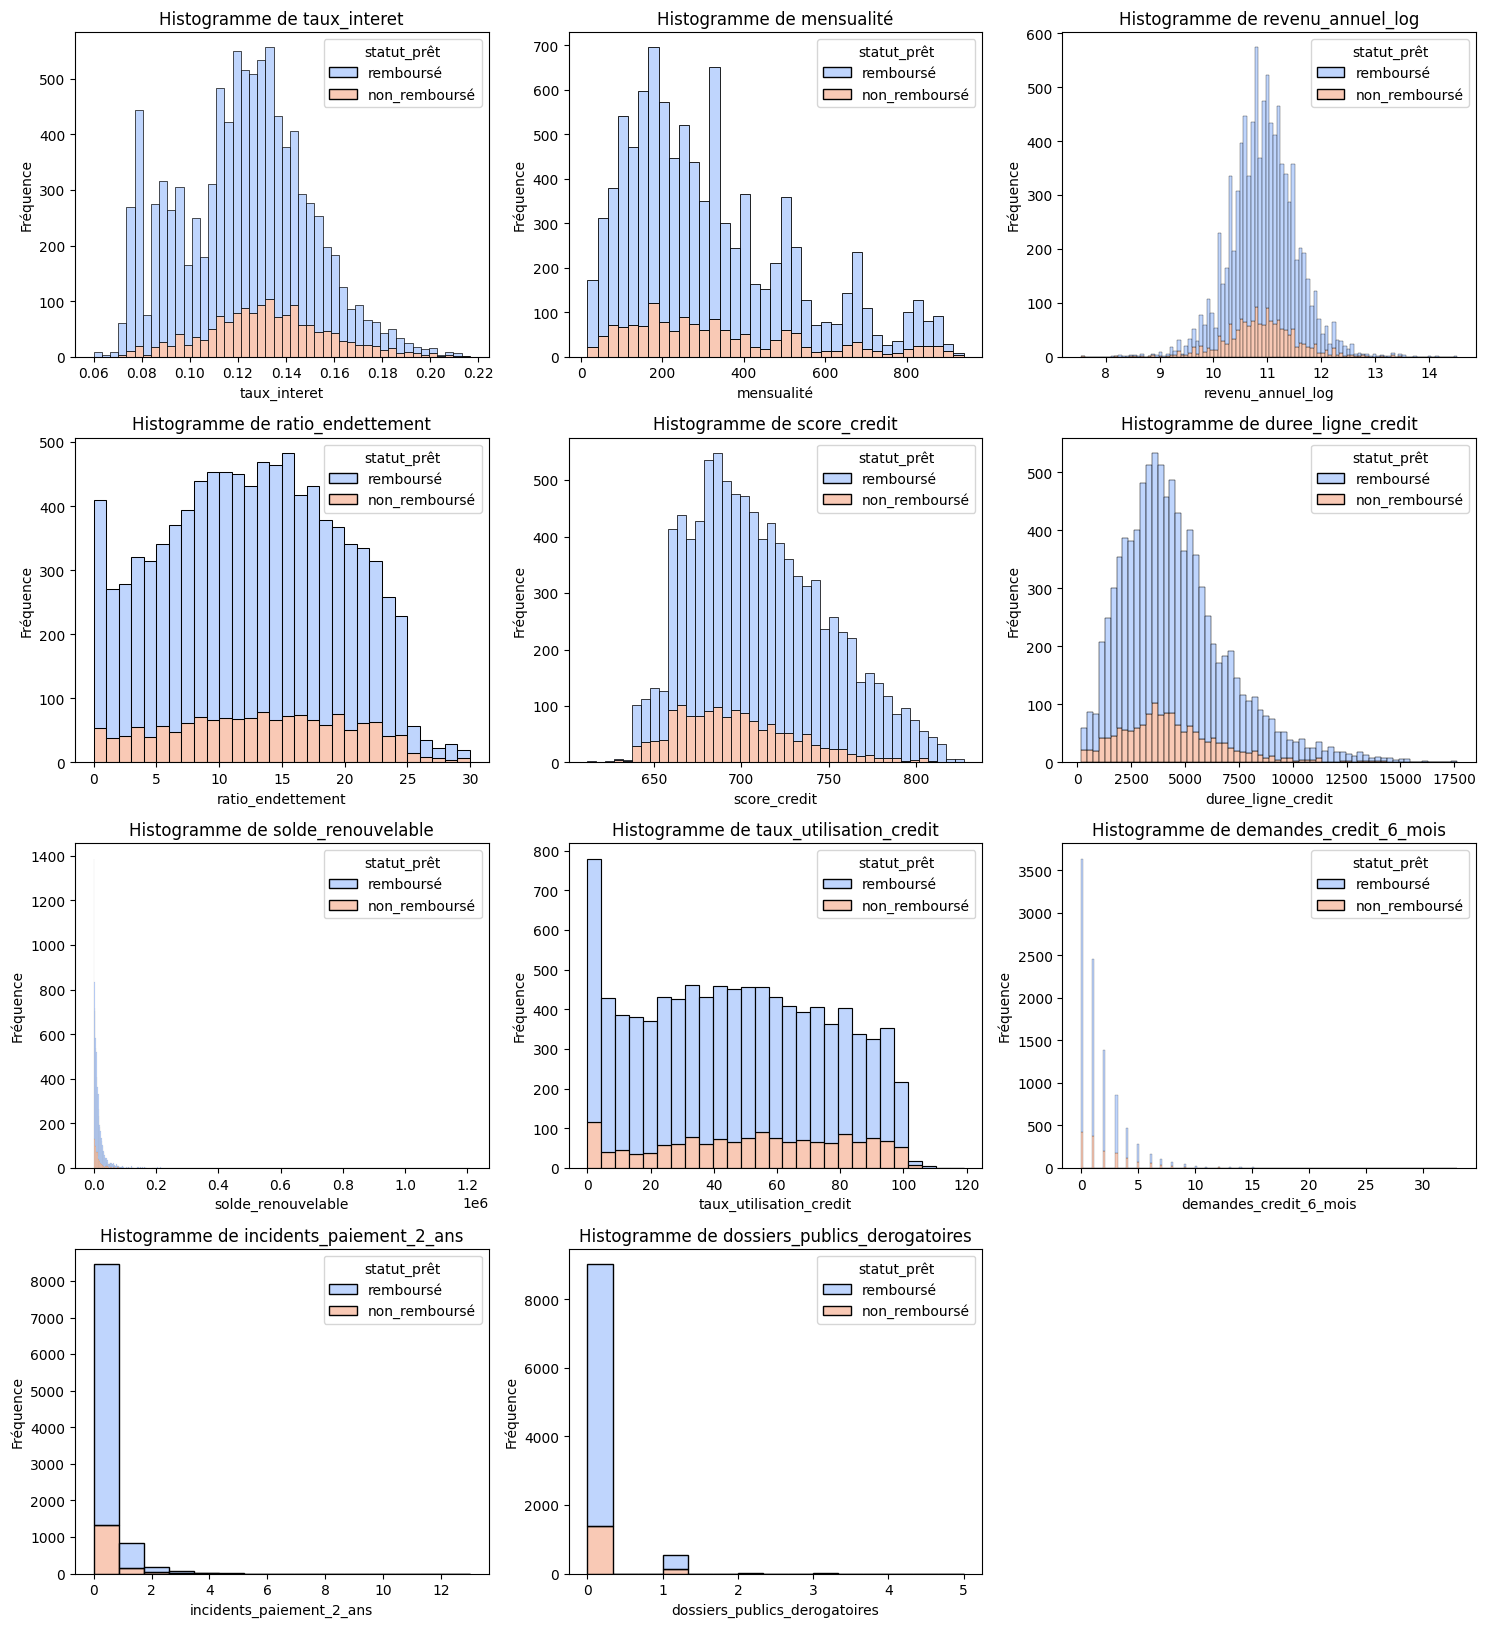

In [30]:
# Sélectionner les colonnes numériques
numeric_data = data.select_dtypes(include=['float64', 'int64'])
numeric_columns = numeric_data.columns

# Afficher les histogrammes des variables numériques
plt.figure(figsize=(15, 20))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data, x=column, hue='statut_prêt', kde=False, multiple="stack", palette="coolwarm")
    plt.title(f'Histogramme de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


In [31]:
# Copier les données pour ne pas modifier l'original
data_encoded = data.copy()

# Créer un encodeur de label
label_encoder = LabelEncoder()

# Encodage des colonnes catégorielles
data_encoded['objet__du_pret'] = label_encoder.fit_transform(data_encoded['objet__du_pret'])
data_encoded['politique_de_credit'] = label_encoder.fit_transform(data_encoded['politique_de_credit'])

# Affichage des premières lignes des données encodées
data_encoded.head()


,politique_de_credit,objet__du_pret,taux_interet,mensualité,revenu_annuel_log,ratio_endettement,score_credit,duree_ligne_credit,solde_renouvelable,taux_utilisation_credit,demandes_credit_6_mois,incidents_paiement_2_ans,dossiers_publics_derogatoires,statut_prêt
0,1,3,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,remboursé
1,1,2,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,remboursé
2,1,3,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,remboursé
3,1,3,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,remboursé
4,1,2,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,remboursé


In [32]:
# Séparation des données en features (X) et target (y)
X = data_encoded.drop(columns=['statut_prêt'])
y = data_encoded['statut_prêt']

# Vérification des dimensions et de la structure des features et de la target
print("\nDimensions des features (X) :", X.shape)
print("Dimensions de la target (y) :", y.shape)
print("\nAperçu des features (X) :")
print(X.head())
print("\nAperçu de la target (y) :")
print(y.value_counts())



Dimensions des features (X) : (9578, 13)
Dimensions de la target (y) : (9578,)

Aperçu des features (X) :
   politique_de_credit  objet__du_pret  taux_interet  mensualité  \
0                    1               3        0.1189      829.10   
1                    1               2        0.1071      228.22   
2                    1               3        0.1357      366.86   
3                    1               3        0.1008      162.34   
4                    1               2        0.1426      102.92   

   revenu_annuel_log  ratio_endettement  score_credit  duree_ligne_credit  \
0          11.350407              19.48           737         5639.958333   
1          11.082143              14.29           707         2760.000000   
2          10.373491              11.63           682         4710.000000   
3          11.350407               8.10           712         2699.958333   
4          11.299732              14.97           667         4066.000000   

   solde_renouvelable

In [33]:
print("Distribution des classes dans l'ensemble de données complet :")
print(y.value_counts())

Distribution des classes dans l'ensemble de données complet :
statut_prêt
remboursé        8045
non_remboursé    1533
Name: count, dtype: int64


In [34]:
# Séparation en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des distributions des classes
print("Distribution des classes dans l'ensemble d'entraînement :")
print(y_train.value_counts())

print("Distribution des classes dans l'ensemble de test :")
print(y_test.value_counts())


Distribution des classes dans l'ensemble d'entraînement :
statut_prêt
remboursé        6436
non_remboursé    1226
Name: count, dtype: int64
Distribution des classes dans l'ensemble de test :
statut_prêt
remboursé        1609
non_remboursé     307
Name: count, dtype: int64


In [35]:
# Mapping the target labels 'non_remboursé' and 'remboursé' to 1 and 0, respectively
y_train = y_train.map({'non_remboursé': 1, 'remboursé': 0})
y_test = y_test.map({'non_remboursé': 1, 'remboursé': 0})

# Combine X_train and y_train to facilitate resampling
train_data = pd.concat([X_train, y_train], axis=1)

# Check the unique values after conversion
unique_values = train_data['statut_prêt'].unique()

# Separate the majority and minority classes
majority_class = train_data[train_data['statut_prêt'] == 0]
minority_class = train_data[train_data['statut_prêt'] == 1]

# Check the sizes of the classes before resampling
majority_class_size = len(majority_class)
minority_class_size = len(minority_class)

# Perform resampling if minority class exists
if not minority_class.empty:
    minority_class_upsampled = resample(minority_class,
                                        replace=True,  # Sample with replacement
                                        n_samples=len(majority_class),  # Match majority class size
                                        random_state=42)

    # Combine upsampled minority class with the majority class
    train_data_balanced = pd.concat([majority_class, minority_class_upsampled])

    # Split X and y again
    X_train_balanced = train_data_balanced.drop('statut_prêt', axis=1)
    y_train_balanced = train_data_balanced['statut_prêt']

    # Check the new distribution after resampling
    y_train_balanced_distribution = y_train_balanced.value_counts()
else:
    y_train_balanced_distribution = "Erreur : La classe minoritaire est absente dans l'ensemble d'entraînement."

unique_values, majority_class_size, minority_class_size, y_train_balanced_distribution


(array([0, 1]),
 6436,
 1226,
 statut_prêt
 0    6436
 1    6436
 Name: count, dtype: int64)

In [36]:
# Entraîner le modèle avec les données équilibrées
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['remboursé (0)', 'non_remboursé (1)'])
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print("Matrice de confusion :")
print(conf_matrix)
print("\nRapport de classification :")
print(class_report)
print("\nScore AUC ROC :")
print(roc_auc)


Matrice de confusion :
[[1580   29]
 [ 291   16]]

Rapport de classification :
                   precision    recall  f1-score   support

    remboursé (0)       0.84      0.98      0.91      1609
non_remboursé (1)       0.36      0.05      0.09       307

         accuracy                           0.83      1916
        macro avg       0.60      0.52      0.50      1916
     weighted avg       0.77      0.83      0.78      1916


Score AUC ROC :
0.5170468233450684


In [41]:
# Entraîner le Decision Tree Classifier avec l'ensemble équilibré
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_balanced, y_train_balanced)

# Prédire les résultats sur l'ensemble de test
y_pred = dt_classifier.predict(X_test)

# Générer la matrice de confusion et le rapport de classification
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Matrice de confusion sous forme de DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['remboursé', 'non_remboursé'], 
                              columns=['prédit_remboursé', 'prédit_non_remboursé'])

# Rapport de classification sous forme de DataFrame
class_report_df = pd.DataFrame(report_dict).transpose()

# Arrondir à deux décimales pour plus de lisibilité avec DataFrame.apply
class_report_df = class_report_df.apply(lambda x: np.round(x, 2) if np.issubdtype(x.dtype, np.number) else x)

# Afficher les résultats
conf_matrix_df, class_report_df


(               prédit_remboursé  prédit_non_remboursé
 remboursé                  1339                   270
 non_remboursé               228                    79,
               precision  recall  f1-score  support
 0                  0.85    0.83      0.84  1609.00
 1                  0.23    0.26      0.24   307.00
 accuracy           0.74    0.74      0.74     0.74
 macro avg          0.54    0.54      0.54  1916.00
 weighted avg       0.75    0.74      0.75  1916.00)

Matrice de confusion :

Le modèle a correctement prédit 1 341 prêts remboursés et a fait 268 erreurs en prédisant des prêts non remboursés alors qu'ils étaient remboursés.
Il a correctement identifié 69 prêts non remboursés, mais a fait 238 erreurs en prédisant qu'ils seraient remboursés alors qu'ils ne l'étaient pas.
Rapport de classification :

Précision (precision) :

Remboursé : 0.85 (le modèle est précis dans la prédiction des prêts remboursés).
Non remboursé : 0.20 (le modèle est moins précis pour prédire les prêts non remboursés).
Rappel (recall) :

Remboursé : 0.83 (le modèle a bien identifié les prêts remboursés).
Non remboursé : 0.22 (seulement 22% des prêts non remboursés sont correctement identifiés).
F1-Score :

Remboursé : 0.84 (équilibre entre précision et rappel pour les prêts remboursés).
Non remboursé : 0.21 (le modèle a des difficultés à bien identifier les prêts non remboursés).
Exactitude globale (accuracy) : 0.74, ce qui montre que le modèle est globalement correct à 74% dans ses prédictions.

Conclusion :
Le modèle fonctionne bien pour prédire les prêts remboursés, mais il a du mal à identifier correctement les prêts non remboursés, avec une faible précision et un rappel limité pour cette classe. Cela reflète un déséquilibre persistant malgré l'équilibrage des classes dans l'entraînement.

In [43]:
# Initialiser le Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Entraîner le modèle avec les données suréchantillonnées
gb_classifier.fit(X_train_balanced, y_train_balanced)

# Prédire les résultats sur l'ensemble de test
y_pred_gb = gb_classifier.predict(X_test)

# Générer la matrice de confusion et le rapport de classification pour le Gradient Boosting Classifier
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb, target_names=['Remboursé', 'Non remboursé'], output_dict=True)

# Convertir la matrice de confusion en DataFrame
conf_matrix_gb_df = pd.DataFrame(conf_matrix_gb, 
                                 index=['Remboursé', 'Non remboursé'], 
                                 columns=['Prédit Remboursé', 'Prédit Non remboursé'])

# Convertir le rapport de classification en DataFrame et arrondir à 2 décimales
class_report_gb_df = pd.DataFrame(class_report_gb).transpose().apply(lambda x: np.round(x, 2))

# Afficher les résultats
conf_matrix_gb_df, class_report_gb_df


(               Prédit Remboursé  Prédit Non remboursé
 Remboursé                  1099                   510
 Non remboursé               121                   186,
                precision  recall  f1-score  support
 Remboursé           0.90    0.68      0.78  1609.00
 Non remboursé       0.27    0.61      0.37   307.00
 accuracy            0.67    0.67      0.67     0.67
 macro avg           0.58    0.64      0.57  1916.00
 weighted avg        0.80    0.67      0.71  1916.00)

Prêts remboursés (Remboursé) : Le modèle obtient une bonne précision (88%) et un rappel acceptable (71%), ce qui signifie qu'il identifie correctement la majorité des prêts remboursés, bien que près de 30% soient classés incorrectement.

Prêts non remboursés (Non remboursé) : La précision (24%) est faible, mais le rappel est meilleur (49%), indiquant que le modèle parvient à capter presque la moitié des prêts non remboursés. Cependant, il produit encore de nombreux faux positifs en classant incorrectement des prêts remboursés comme non remboursés.

Exactitude globale : Le modèle a une précision globale de 67%, ce qui est un peu inférieur à ce que l'on pourrait espérer pour un modèle de production.

En résumé, bien que le Gradient Boosting montre une amélioration en termes de rappel pour la classe "non remboursé" par rapport au Decision Tree, il reste encore un déséquilibre dans la capacité à prédire correctement les prêts non remboursés. Des optimisations supplémentaires seraient nécessaires pour améliorer la prédiction de cette classe.

In [44]:
# Initialiser le modèle de régression logistique
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Entraîner le modèle avec les données suréchantillonnées
logreg_classifier.fit(X_train_balanced, y_train_balanced)

# Prédire les résultats sur l'ensemble de test
y_pred_logreg = logreg_classifier.predict(X_test)

# Générer la matrice de confusion et le rapport de classification pour la régression logistique
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg, target_names=['Remboursé', 'Non remboursé'], output_dict=True)

# Convertir la matrice de confusion en DataFrame
conf_matrix_logreg_df = pd.DataFrame(conf_matrix_logreg, 
                                     index=['Remboursé', 'Non remboursé'], 
                                     columns=['Prédit Remboursé', 'Prédit Non remboursé'])

# Convertir le rapport de classification en DataFrame et arrondir à 2 décimales
class_report_logreg_df = pd.DataFrame(class_report_logreg).transpose().apply(lambda x: np.round(x, 2))

# Afficher les résultats
conf_matrix_logreg_df, class_report_logreg_df


(               Prédit Remboursé  Prédit Non remboursé
 Remboursé                   940                   669
 Non remboursé               133                   174,
                precision  recall  f1-score  support
 Remboursé           0.88    0.58      0.70  1609.00
 Non remboursé       0.21    0.57      0.30   307.00
 accuracy            0.58    0.58      0.58     0.58
 macro avg           0.54    0.58      0.50  1916.00
 weighted avg        0.77    0.58      0.64  1916.00)

La régression logistique montre un rappel élevé (52%) pour les prêts non remboursés, mais sa précision est encore faible (23%). L'exactitude globale est de 64%, avec une performance similaire au Gradient Boosting. ​